In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=10, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=10, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

In [3]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

In [4]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

In [5]:
 def plot_shared_snps(f_pca, mask, names, title=""):
    combs = []
    combs_nums = []
    combinations = []

    for m in mask:
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1
        combinations.append(combs.index(cur))

    df = pd.DataFrame({'pc1':f_pca[:, 0], 'pc2':f_pca[:, 1], 'combination':combinations})
    df_valid = df.loc[df['combination'] != -1]

    # reoder combinations by sizes of groups
    order = sorted(zip(combs_nums, combs, range(12)), reverse=True)
    new_comb_order = [0] * (2 ** len(mask[0]))
    new_comb_names = [] 
    for i in range(len(order)):
        old_order = order[i][2]
        new_comb_order[old_order] = i
        new_comb_names.append('{:5d}'.format(order[i][0]) + '  ' + order[i][1])
    for i in df_valid.index:
        df_valid.loc[i, "combination"] = new_comb_order[df_valid.loc[i, "combination"]]

    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    color_palette = sns.color_palette(colors)
    cluster_colors = [color_palette[x] for x in df_valid["combination"]]

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.scatter(df_valid["pc1"], df_valid["pc2"], s=40, linewidth=0, c=cluster_colors, alpha=0.6);
    draw_legend(color_palette, new_comb_names, right=True)
    plt.title(title)

In [6]:
 def sizes_of_groups(mask, names):
    combs = []
    combs_nums = []

    for m in mask:
        cur = ""
        for i in range(len(m)):
            if m[i] == 1:
                if cur != "":
                    cur += " + "
                cur += names[i]                    
        if cur not in combs:
            combs.append(cur)
            combs_nums.append(0)
        combs_nums[combs.index(cur)] += 1

    df = pd.DataFrame({'size':combs_nums, 'description':combs})
    df = df.sort_values(by='size', ascending=False)
    df = df.reset_index(drop=True)
    return df

In [7]:
names = ["K12", "EDL", "TW", "IAI39"]

# Считываем данные

In [13]:
def stats_all(experiment_name):
    r = np.genfromtxt("%s/matrices/R_all" % experiment_name, dtype=int, delimiter=' ')
    x = np.genfromtxt("%s/matrices/X_all" % experiment_name, dtype=int, delimiter=' ')
    print("%s sites" % len(r), "\n")

    mask = x[:, 0:4]
    mask[mask > 0] = 1
    r = np.delete(r, [0, 1, 2, 3], axis=1)
    x = np.delete(x, [0, 1, 2, 3], axis=1)

    Ncut = 5
    print("Delete zero and almost zero profiles:")
    good_ind = [i for i in range(np.shape(x)[0]) 
                if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
    print(len(good_ind), "remained", "\n")

    x = x[good_ind, :]
    r = r[good_ind, :]
    mask = mask[good_ind, :]

    f = np.divide(x, r)
    f_pca = PCA(n_components=2).fit(f).transform(f)

    draw_PCA(f_pca, filter_by_coverage(r, 15, 2))

    plot_shared_snps(f_pca, mask, names, title="before filtration")

    # coverage filtering
    good_coverage = filter_by_coverage(r, 15, 2)
    mask_filtered = mask[good_coverage, :]

    f_withoutT_filtered = np.divide(x, r)[good_coverage, :]
    f_pca_withoutT_filtered = PCA(n_components=2).fit(f_withoutT_filtered).transform(f_withoutT_filtered)

    plot_shared_snps(f_pca_withoutT_filtered, mask_filtered, names, title="after filtration")

    print("Before filtration")
    print(sizes_of_groups(mask, names), "\n")

    print("After filtration")
    print(sizes_of_groups(mask_filtered, names))

# EDL

115144 sites 

Delete zero and almost zero profiles:
114862 remained 

Before filtration
        description   size
0             IAI39  55754
1       K12 + IAI39  30374
2               K12  27833
3  K12 + TW + IAI39    543
4                TW    288
5        TW + IAI39     41
6          K12 + TW     29 

After filtration
        description   size
0             IAI39  20614
1       K12 + IAI39  10576
2               K12  10099
3  K12 + TW + IAI39    126
4                TW    101
5        TW + IAI39      5
6          K12 + TW      3


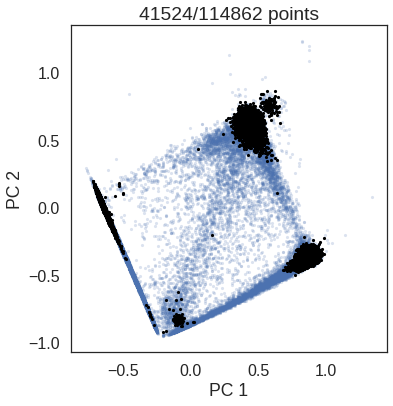

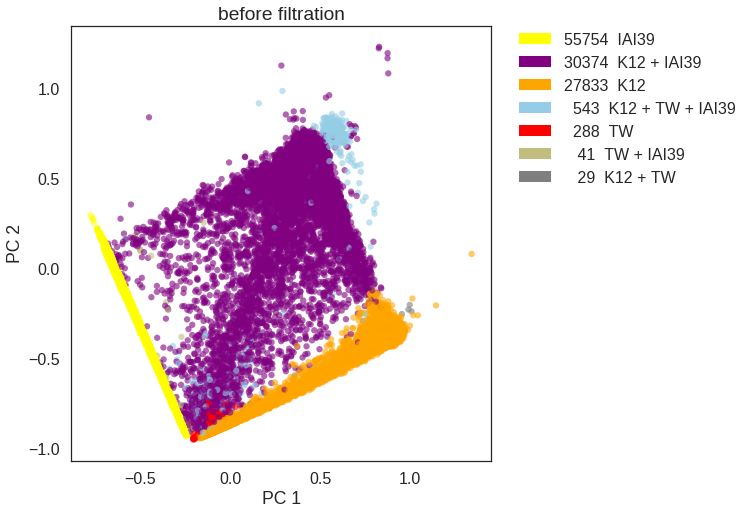

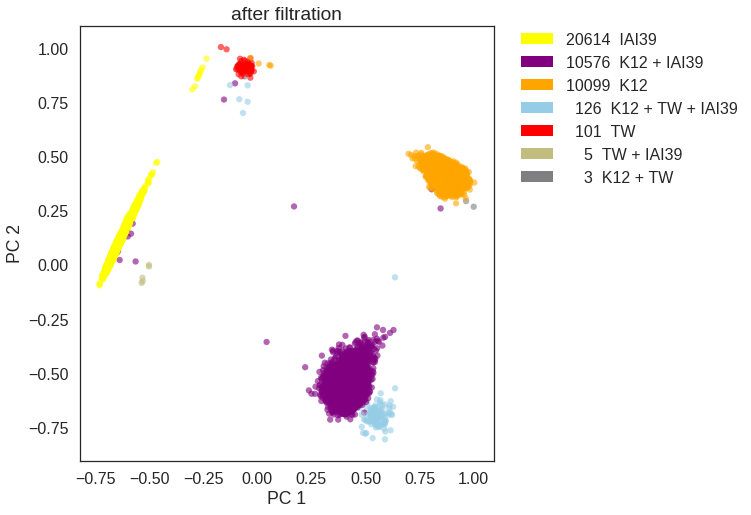

In [14]:
stats_all("4ecoli_pure_EDL")

# TW

114951 sites 

Delete zero and almost zero profiles:
114709 remained 

Before filtration
         description   size
0              IAI39  55794
1        K12 + IAI39  30423
2                K12  27846
3                EDL    305
4  K12 + EDL + IAI39    291
5          K12 + EDL     28
6        EDL + IAI39     22 

After filtration
         description   size
0              IAI39  20688
1        K12 + IAI39  10588
2                K12  10170
3                EDL     99
4  K12 + EDL + IAI39     96
5          K12 + EDL      4
6        EDL + IAI39      3


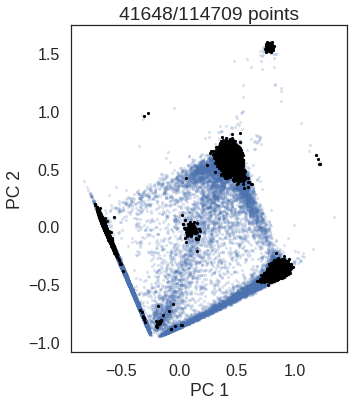

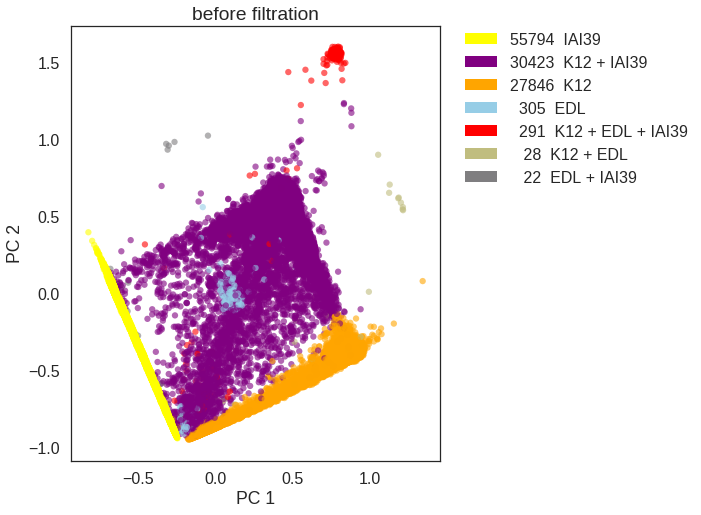

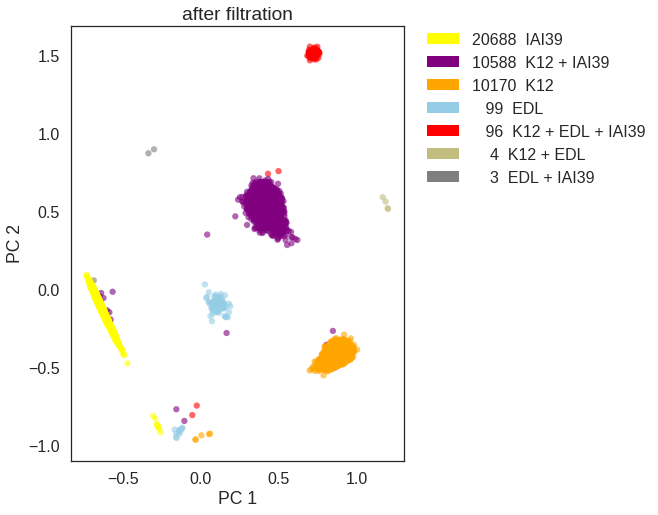

In [15]:
stats_all("4ecoli_pure_TW")

# K12

112375 sites 

Delete zero and almost zero profiles:
112131 remained 

Before filtration
        description   size
0             IAI39  55649
1          EDL + TW  29026
2  EDL + TW + IAI39  26851
3                TW    268
4               EDL    265
5        TW + IAI39     54
6       EDL + IAI39     18 

After filtration
        description   size
0             IAI39  21677
1          EDL + TW  11302
2  EDL + TW + IAI39  10062
3                TW    110
4               EDL     93
5       EDL + IAI39      6
6        TW + IAI39      5


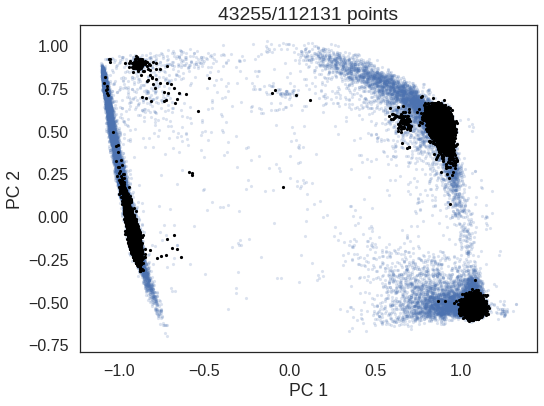

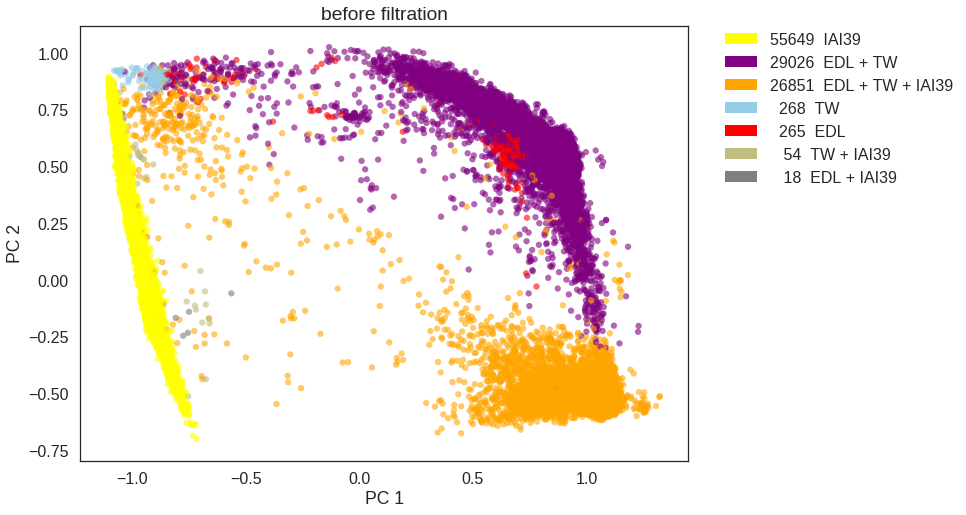

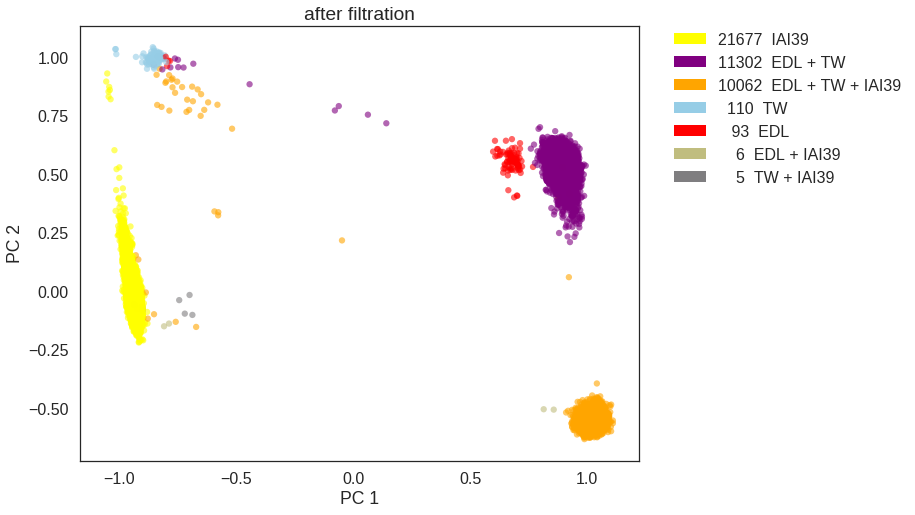

In [16]:
stats_all("4ecoli_pure_K12")

# IAI39

109638 sites 

Delete zero and almost zero profiles:
109528 remained 

Before filtration
      description   size
0  K12 + EDL + TW  52836
1        EDL + TW  28384
2             K12  27720
3             EDL    278
4              TW    259
5        K12 + TW     29
6       K12 + EDL     22 

After filtration
      description   size
0  K12 + EDL + TW  23685
1        EDL + TW  13029
2             K12  12257
3              TW    121
4             EDL    105
5       K12 + EDL      6
6        K12 + TW      4


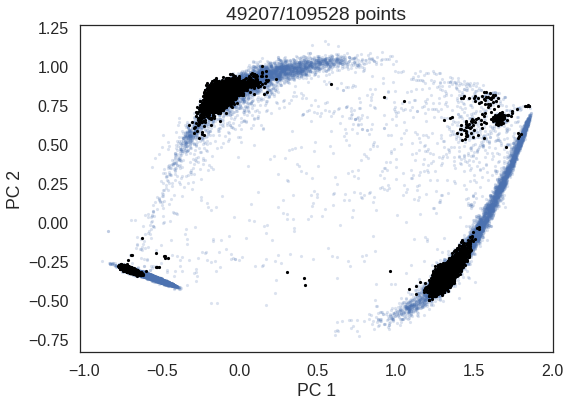

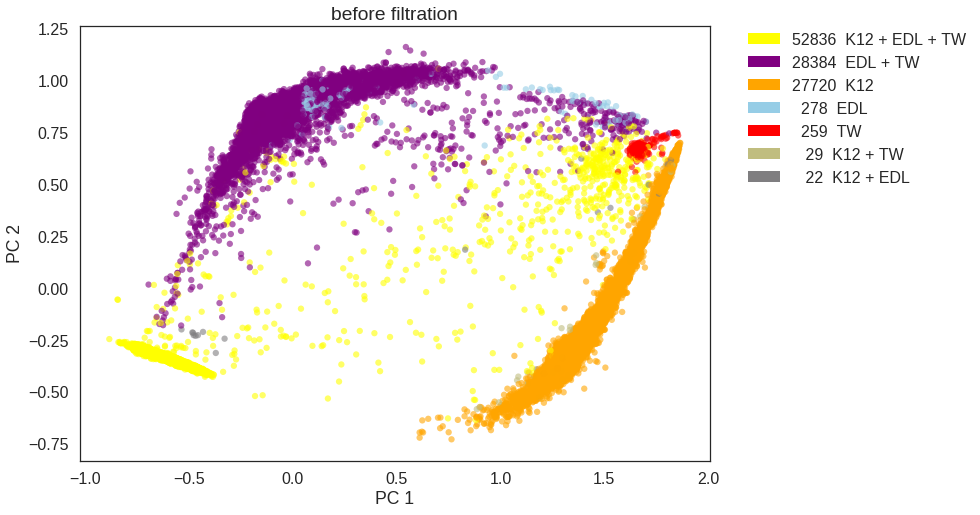

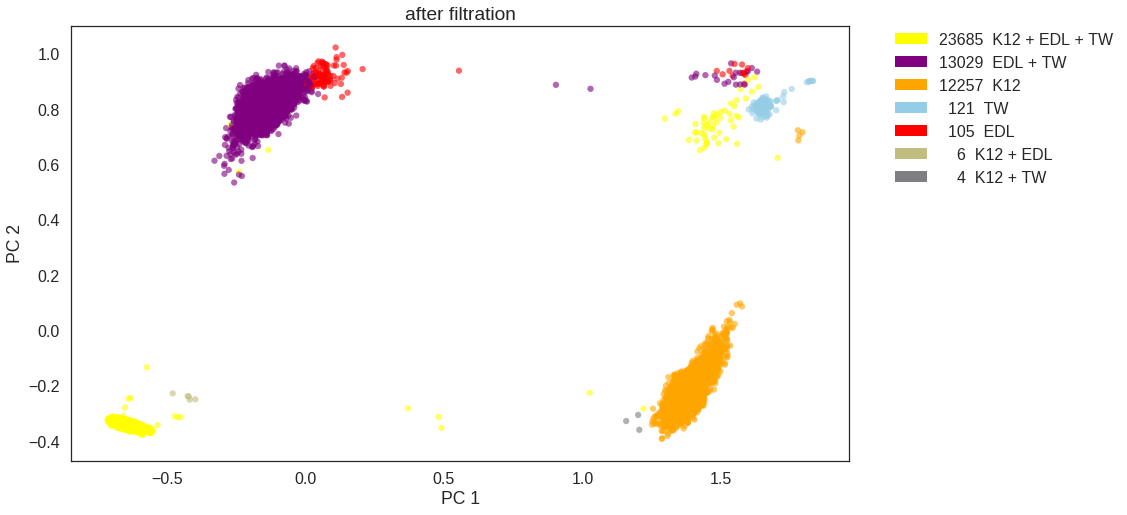

In [17]:
stats_all("4ecoli_pure_IAI39")

# B

119292 sites 

Delete zero and almost zero profiles:
110044 remained 

Before filtration
               description   size
0                    IAI39  49583
1                 EDL + TW  24620
2         EDL + TW + IAI39  17377
3                      K12   9259
4           K12 + EDL + TW   4561
5              K12 + IAI39   3822
6                      EDL    264
7                       TW    255
8   K12 + EDL + TW + IAI39    225
9               TW + IAI39     30
10             EDL + IAI39     19
11       K12 + EDL + IAI39      9
12                K12 + TW      8
13        K12 + TW + IAI39      7
14               K12 + EDL      5 

After filtration
               description   size
0                    IAI39  20286
1                 EDL + TW  10029
2         EDL + TW + IAI39   6729
3                      K12   3732
4           K12 + EDL + TW   1743
5              K12 + IAI39   1449
6                       TW    109
7                      EDL    100
8   K12 + EDL + TW + IAI39      9
9       

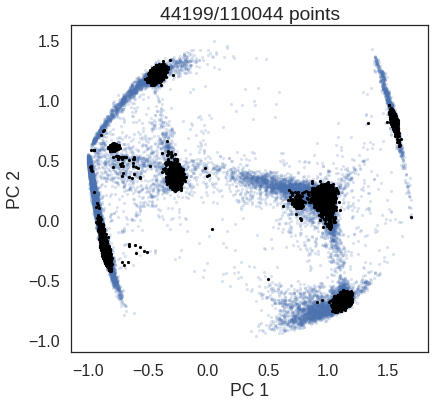

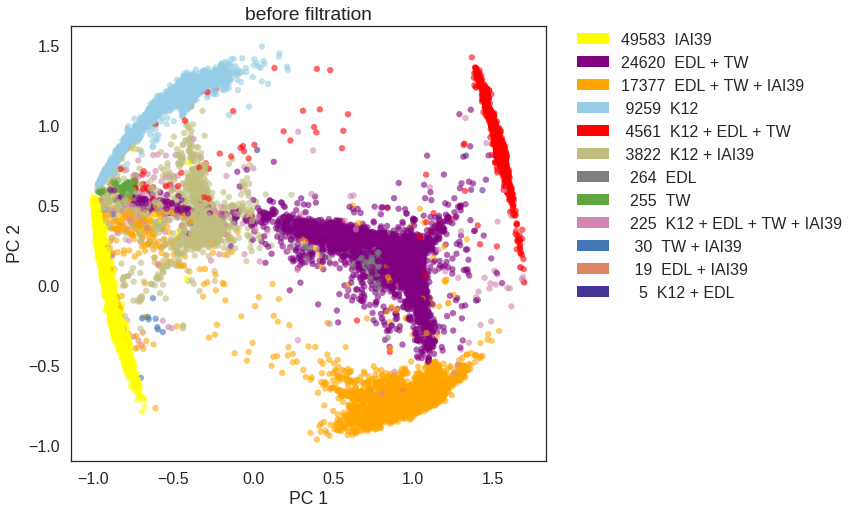

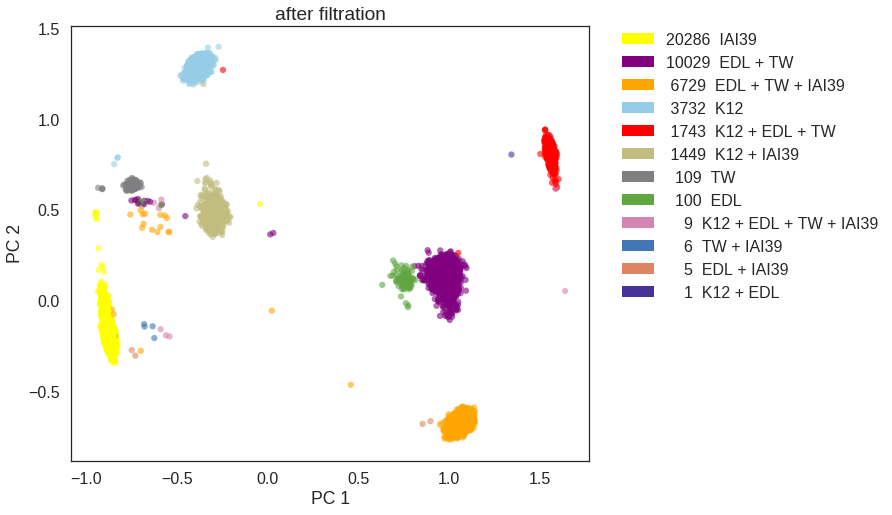

In [19]:
stats_all("4ecoli_pure_B")

# P12b

116406 sites 

Delete zero and almost zero profiles:
109897 remained 

Before filtration
               description   size
0                    IAI39  51369
1                 EDL + TW  25891
2         EDL + TW + IAI39  20371
3                      K12   5962
4           K12 + EDL + TW   2805
5              K12 + IAI39   2430
6   K12 + EDL + TW + IAI39    467
7                      EDL    271
8                       TW    257
9               TW + IAI39     36
10             EDL + IAI39     14
11               K12 + EDL      7
12                K12 + TW      7
13       K12 + EDL + IAI39      6
14        K12 + TW + IAI39      4 

After filtration
               description   size
0                    IAI39  21283
1                 EDL + TW  10721
2         EDL + TW + IAI39   8112
3                      K12   2449
4           K12 + EDL + TW   1081
5              K12 + IAI39    907
6                      EDL    104
7                       TW    103
8   K12 + EDL + TW + IAI39     75
9       

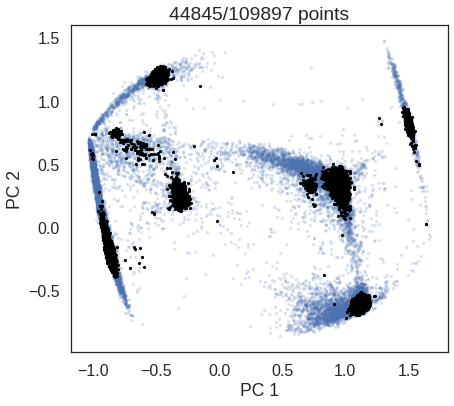

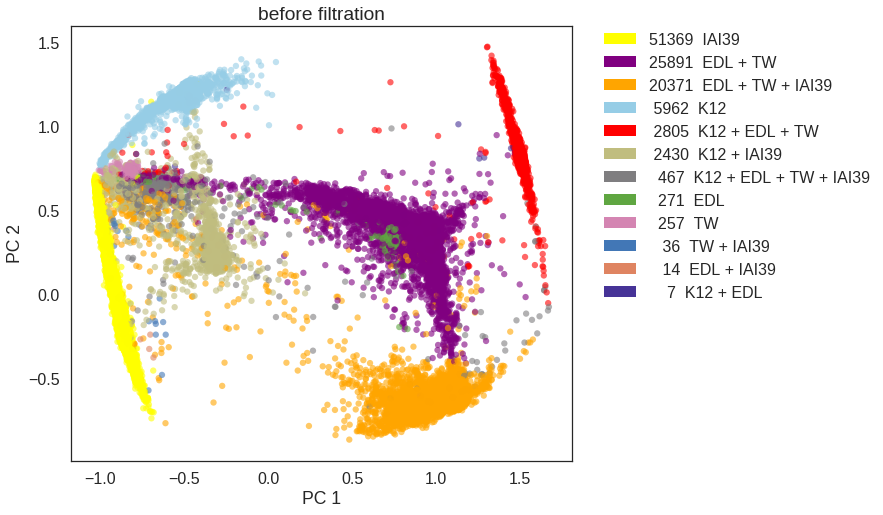

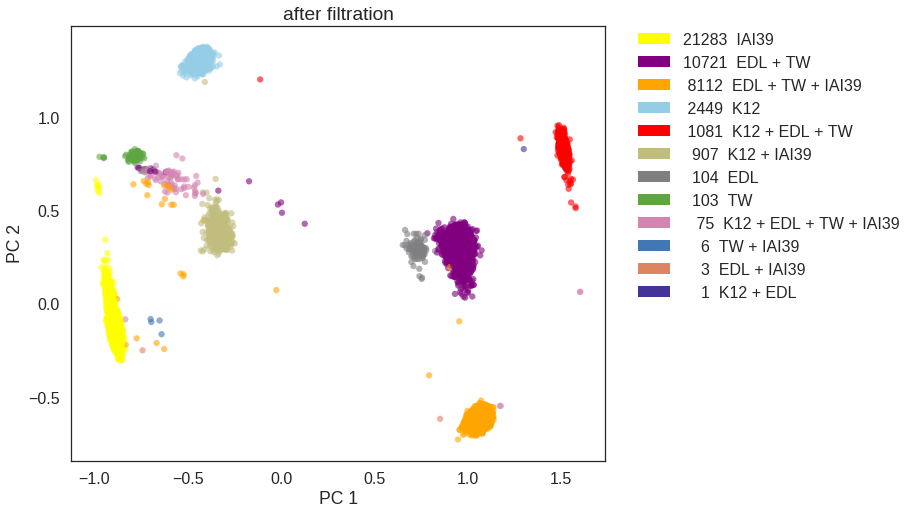

In [24]:
stats_all("4ecoli_pure_P12b")

# O104

126125 sites 

Delete zero and almost zero profiles:
110624 remained 

Before filtration
               description   size
0                    IAI39  47528
1                 EDL + TW  22226
2                      K12  14426
3         EDL + TW + IAI39  12404
4           K12 + EDL + TW   6788
5              K12 + IAI39   6339
6   K12 + EDL + TW + IAI39    301
7                       TW    271
8                      EDL    255
9               TW + IAI39     20
10       K12 + EDL + IAI39     20
11             EDL + IAI39     15
12               K12 + EDL     13
13        K12 + TW + IAI39     10
14                K12 + TW      8 

After filtration
               description   size
0                    IAI39  19438
1                 EDL + TW   9227
2                      K12   5835
3         EDL + TW + IAI39   4850
4           K12 + EDL + TW   2725
5              K12 + IAI39   2360
6                       TW    109
7                      EDL     99
8   K12 + EDL + TW + IAI39     18
9       

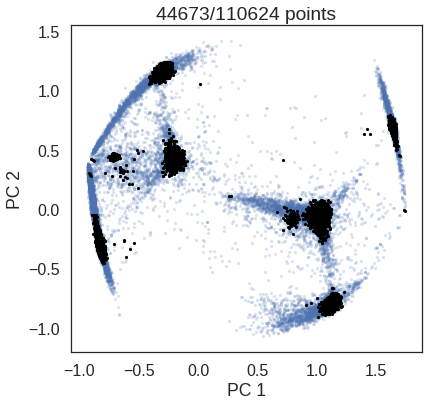

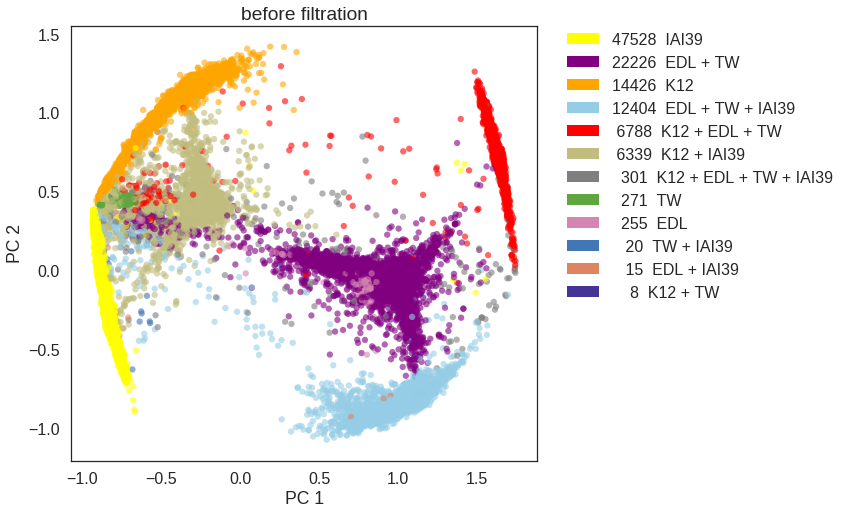

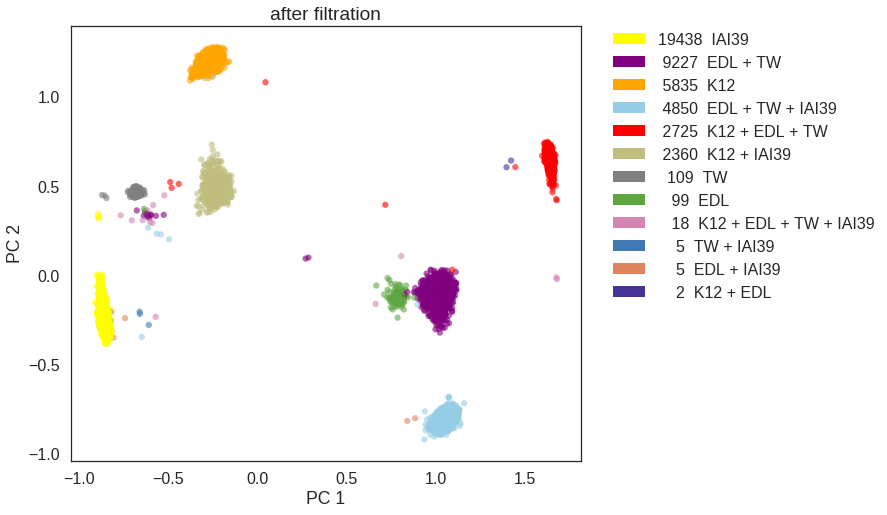

In [23]:
stats_all("4ecoli_pure_O104")

# SMS

128945 sites 

Delete zero and almost zero profiles:
109607 remained 

Before filtration
               description   size
0           K12 + EDL + TW  32822
1                 EDL + TW  24679
2                      K12  23765
3                    IAI39  20278
4              K12 + IAI39   3677
5         EDL + TW + IAI39   3464
6   K12 + EDL + TW + IAI39    333
7                      EDL    272
8                       TW    246
9                K12 + EDL     20
10                K12 + TW     16
11              TW + IAI39     12
12        K12 + TW + IAI39     12
13             EDL + IAI39      7
14       K12 + EDL + IAI39      4 

After filtration
               description   size
0           K12 + EDL + TW  14262
1                 EDL + TW  11229
2                      K12  10382
3                    IAI39   8918
4              K12 + IAI39   1548
5         EDL + TW + IAI39   1427
6                       TW    121
7                      EDL    112
8   K12 + EDL + TW + IAI39     21
9       

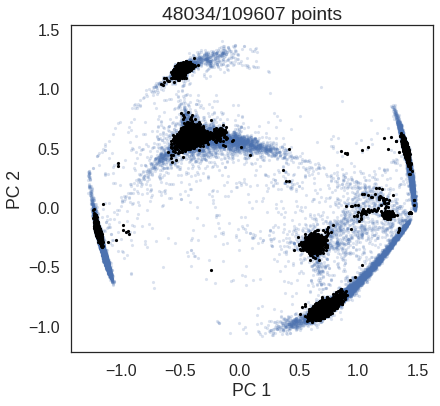

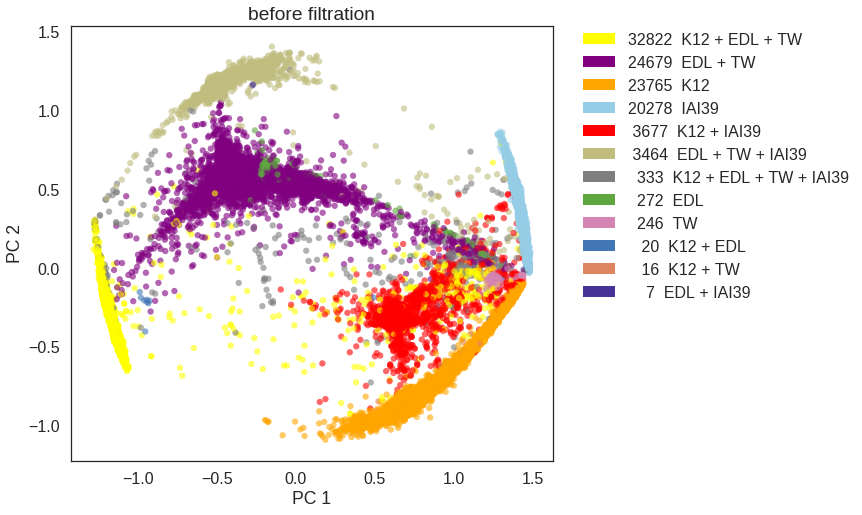

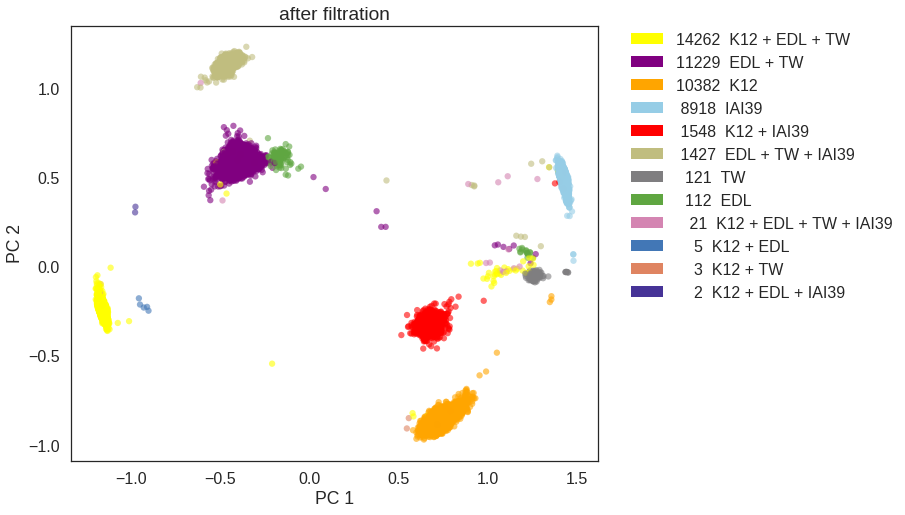

In [22]:
stats_all("4ecoli_pure_SMS")

# UTI

136254 sites 

Delete zero and almost zero profiles:
102178 remained 

Before filtration
               description   size
0                    IAI39  27588
1           K12 + EDL + TW  22283
2                 EDL + TW  21071
3                      K12  20422
4              K12 + IAI39   5241
5         EDL + TW + IAI39   4560
6   K12 + EDL + TW + IAI39    478
7                      EDL    247
8                       TW    225
9                 K12 + TW     15
10               K12 + EDL     13
11        K12 + TW + IAI39     12
12              TW + IAI39     11
13       K12 + EDL + IAI39      8
14             EDL + IAI39      4 

After filtration
               description   size
0                    IAI39  12625
1           K12 + EDL + TW  10103
2                 EDL + TW  10040
3                      K12   9302
4              K12 + IAI39   2194
5         EDL + TW + IAI39   1978
6                       TW    114
7                      EDL    104
8   K12 + EDL + TW + IAI39     60
9       

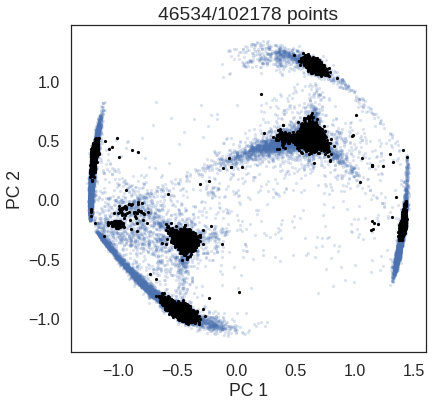

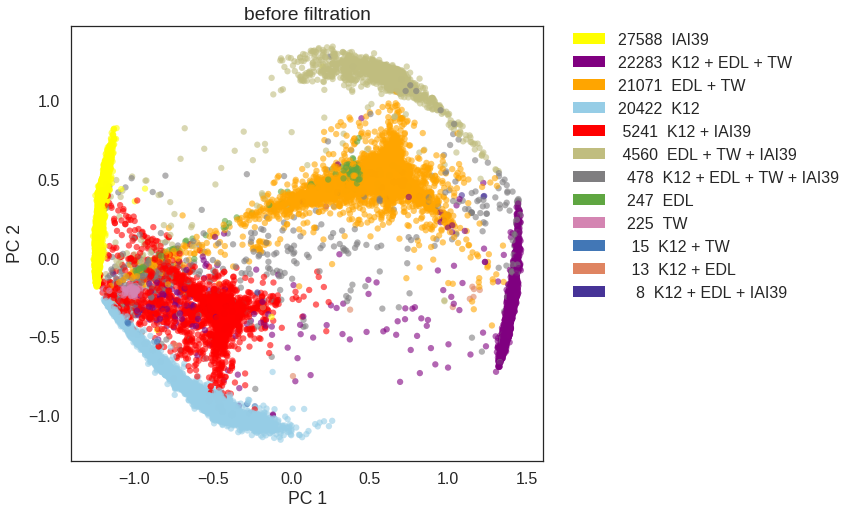

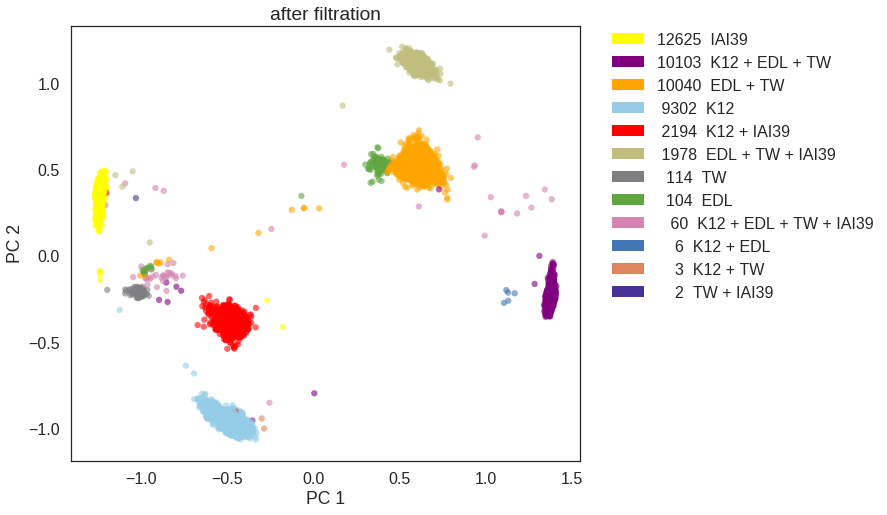

In [21]:
stats_all("4ecoli_pure_UTI")

# H6

135098 sites 

Delete zero and almost zero profiles:
101412 remained 

Before filtration
               description   size
0                    IAI39  27429
1           K12 + EDL + TW  22099
2                 EDL + TW  20988
3                      K12  20292
4              K12 + IAI39   5128
5         EDL + TW + IAI39   4460
6   K12 + EDL + TW + IAI39    493
7                      EDL    240
8                       TW    217
9                K12 + EDL     15
10        K12 + TW + IAI39     15
11                K12 + TW     11
12              TW + IAI39     10
13       K12 + EDL + IAI39      9
14             EDL + IAI39      6 

After filtration
               description   size
0                    IAI39  12579
1                 EDL + TW  10134
2           K12 + EDL + TW  10115
3                      K12   9249
4              K12 + IAI39   2203
5         EDL + TW + IAI39   1968
6                       TW    113
7                      EDL    107
8   K12 + EDL + TW + IAI39     58
9       

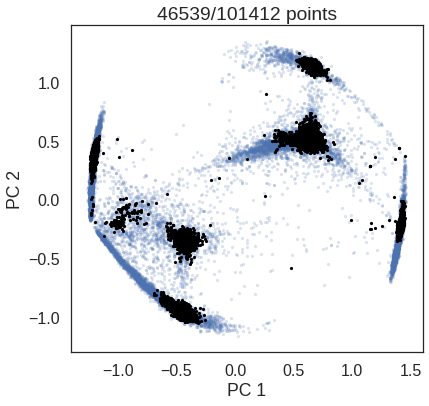

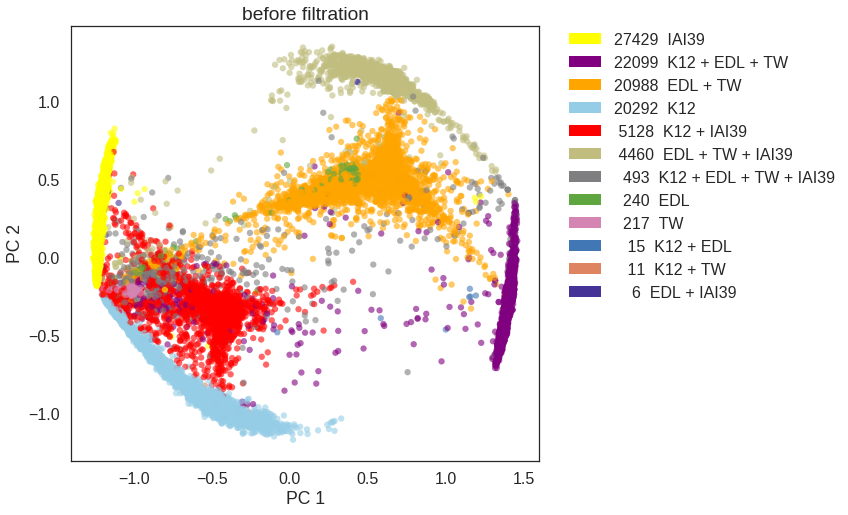

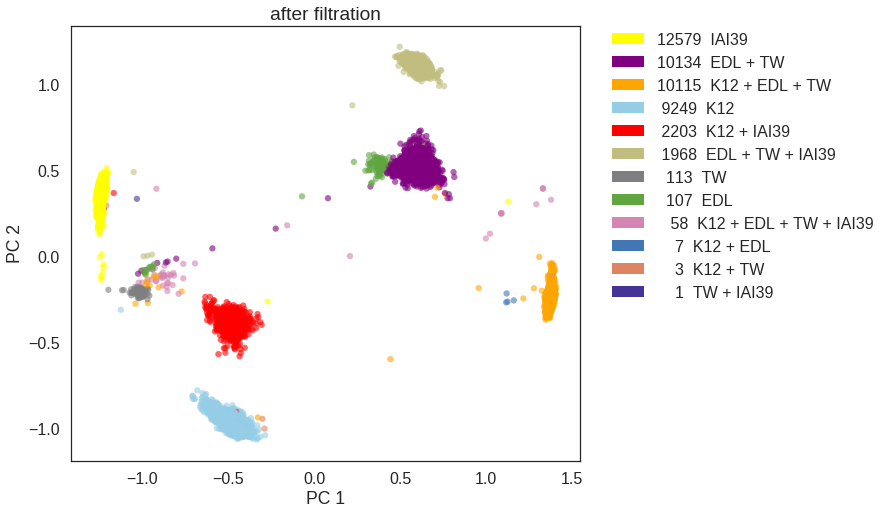

In [20]:
stats_all("4ecoli_pure_H6")